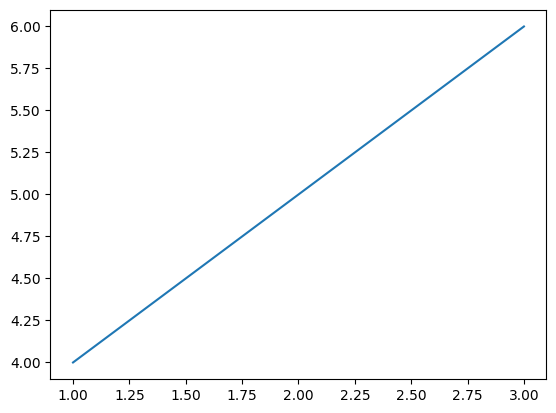

In [10]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3], [4, 5, 6])
plt.show()

In [11]:
x = torch.arange(4.0) #创建张量0123
x.requires_grad_(True) #启用梯度追踪, 这行代码启用了x的梯度计算
x.grad #这个时候看不到x的梯度, 但此时还没有进行反向传播，所以x的梯度应该是None或者全零
y = 2 * torch.dot(x, x) #​定义计算图: 输入x, x平方和, 乘2得到y
y.backward() #使用反向传播 y.backward()自动计算y对x的梯度，并将结果存储在x.grad中, 2x^2求导为4x
x.grad
# 在默认情况下, pytorch会累积梯度, 所以当我们不需要上一次的梯度时, 需要梯度清零
x.grad.zero_()

tensor([0., 0., 0., 0.])

输入=>模型预测=>输出:预估质量的简单衡量--平方损失0.5*(y-y')^2
收集数据点来决定函数的参数值:训练数据
训练损失:1/2n * (y - Xw - b)^2, x,y,W(权重)都是向量
将b加入w向量中, 并在X向量的对应位加一个1,我们就将偏差融入了函数:1/2n * (y - Xw)^2
我们的目的是找到一个w和b使得损失函数最小
所以我们用上了导数的知识:
1/2n * (y - Xw)^2求导得:1/n * (y - Xw)^T X
找到一个最优的w: w*
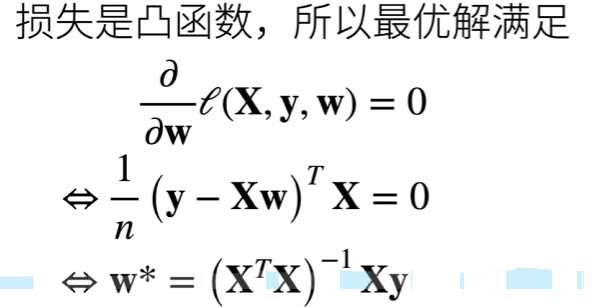

梯度下降的基本思想: 挑选一个w0, 接下来不断更新这个w0, 使其接近最优解
一种迭代的函数:
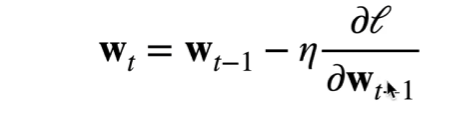
下一个w(t)是上一个w(t-1) - η*(损失函数关于wt-1的梯度)
学习率η(步长):步长的超参数(超参数: 需要自己指定的参数)
学习率不能太少也不能太大: 想象在盆地下山的时候的步长
随机采样b个样本(走几步): 选取b个样本来近似损失, 损失变为: 1/b Σ(损失i)

**神经网络的基本结构**
神经网络由 ​神经元（Neurons）​​ 和 ​层（Layers）​​ 组成。最简单的神经网络是 ​单层神经网络，它只包含：
​输入层：直接接收数据（比如 x₁, x₂, ..., xₙ）
​输出层：生成预测结果（比如 y）
​唯一区别：单层神经网络通常默认没有激活函数（或使用线性激活函数），而线性模型也没有非线性操作。
✅ ​结论：线性模型本质上就是一个没有隐藏层的单层神经网络！
**(1) 神经元（Neuron）​**
​功能：接收多个输入，计算加权和，再通过 ​激活函数​ 输出结果
**(2) 层（Layer）​**
​输入层：直接接收原始数据。
​隐藏层​（可选）：位于输入层和输出层之间，用于提取抽象特征。
​输出层：生成最终预测结果。
​**(3) 激活函数（Activation Function）​**
​作用：引入非线性，使神经网络可以拟合复杂函数。
​常见类型：Sigmoid、ReLU、Tanh 等。
​**(4) 神经网络的深度**
​单层神经网络：只有输入层和输出层（即线性模型）。
​多层神经网络（深度学习）​：包含至少一个隐藏层，例如：
输入层 → 隐藏层（激活函数） → 输出层
举个例子:
​多层神经网络：
输入层：房屋面积、卧室数量。
隐藏层：通过激活函数学习非线性特征（比如“面积和卧室数量的组合效应”）。
输出层：预测房价。
​优势：可以建模复杂关系（比如“面积大但卧室少时，房价反而下降”）。

In [12]:
x = torch.arange(12)
x

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [13]:
#生成一个人造的线性回归数据集，这样我们可以用它来练习和演示线性回归模型的实现。
%matplotlib inline
import torch
import random
from d2l import torch as d2l
# 后面要使用D2L的工具函数生成数据
# features, labels = d2l.synthetic_data(true_w, true_b, 1000)

# 生成一个符合线性关系（y = X*w + b）的假数据集，并添加少量噪声。这个数据集里y 的值等于 X*w + b再包含一点偏差值
# 这样我们既能控制数据的真实规律（知道w和b的值），又能模拟真实数据中的噪声。
def synthetic_data(w, b, num_examples):
    #生成一个形状为 (num_examples, len(w)) 的矩阵，每个元素从均值为0、标准差为1的正态分布中随机采样。
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b # 计算线性模型的预测值（尚未加噪声）
    y += torch.normal(0, 0.01, y.shape) # 为y生成噪声
    return X, y.reshape((-1, 1)) # 将y从一维向量转换为二维矩阵（例如形状从(1000,)变为(1000,1)）。

#下面是针对答案出题:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000) #生成1000个样本，每个样本有2个特征，标签符合 y = 2*x1 -3.4*x2 +4.2 的线性关系，外加微小噪声

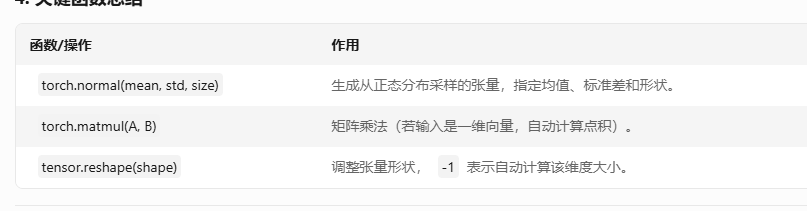

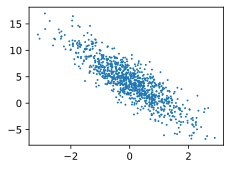

In [14]:
d2l.set_figsize()
# 画第二个特征与标签的关系
d2l.plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

In [15]:
#定义了一个data_iter的函数, 便于分批次处理数据
def data_iter(batch_size, features, labels):
    #batch_size：每个批次包含的样本数量
    #features：特征数据（输入数据）
    #labels：标签数据（目标输出）
    num_examples = len(features) #输入数据总长
    indices = list(range(num_examples))  #indices = list(range(num_examples))：生成 [0, 1, 2, ..., num_examples-1] 的索引列表
    random.shuffle(indices) #​随机打乱索引顺序，确保每个批次的数据是随机的，避免模型学习到数据的顺序性
    #目的是按照某种步长随机读取标签, 获得更少,更随机的数据
    for i in range(0, num_examples, batch_size):
        #从 indices 中截取一段连续的索引作为当前批次并转为tensor
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        #​生成器返回当前批次的 features 和 labels; 一次次地返回
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break
#上面编写了一个将数据整理并处理的函数便于后面的训练(print的位置就可以换成训练代码)

tensor([[-0.9794, -1.2153],
        [-1.5698, -1.3686],
        [ 0.6584,  0.4570],
        [ 1.5423,  0.4159],
        [ 1.9780,  0.5099],
        [ 2.2070,  0.3000],
        [-1.3330, -0.6427],
        [ 0.1372, -0.1007],
        [-0.0233,  0.1817],
        [ 0.7251, -1.1206]]) 
 tensor([[6.3862],
        [5.7205],
        [3.9622],
        [5.8653],
        [6.4243],
        [7.5927],
        [3.7218],
        [4.8194],
        [3.5444],
        [9.4562]])


In [32]:
# w：从均值为0、标准差为0.01的正态分布中随机采样，形状为 (2, 1)
# b：初始化为0，形状为 (1,)。
# requires_grad=True：启用自动求导，PyTorch会跟踪这些张量的计算历史以便计算梯度。
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# 实现线性回归模型  y_hat =Xw+b
def linreg(X, w, b):
    return torch.matmul(X, w) + b

# 计算简化版均方损失（MSE）的函数
def squared_loss(y_hat, y):
    return(y_hat - y.reshape(y_hat.shape))**2 / 2 #y.reshape(y_hat.shape)：确保标签 y 的形状与预测值

def sgd(params, lr, batch_size):
    #params：包含 w 和 b 的列表
    #lr：学习率（learning rate），控制参数更新步长
    #batch_size：批次大小，用于梯度平均
    with torch.no_grad():   #禁用梯度跟踪，避免在参数更新时干扰自动求导
        for param in params:
            param -= lr * param.grad # 按梯度方向更新参数
#梯度指示了损失函数增长最快的方向，因此负梯度方向就是损失函数下降最快的方向。
#通过减去梯度（param -= lr * param.grad），参数会朝着损失函数下降的方向更新。
            param.grad.zero_() # 清空梯度，避免梯度累积

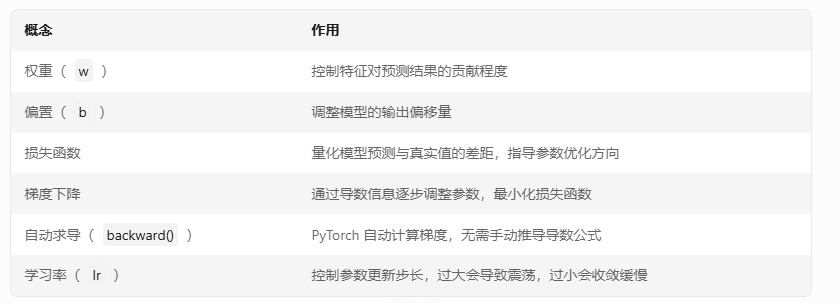

In [33]:
#这样写可以便于我们之后换成其他模型
lr = 0.006 # 学习率（步长）
num_epochs = 3 # 训练轮数
net = linreg # 线性回归模型 "def linreg(X, w, b):"
loss = squared_loss # 平方损失函数


for epoch in range(num_epochs): # 遍历每个训练轮次
    for X, y in data_iter(batch_size, features, labels):  # 遍历每个小批量数据
        l = loss(net(X, w, b), y) # net(X, w, b) 是模型预测值，loss 计算预测值与真实值 y 的损失
        l.sum().backward()  # 将小批量损失求和后反向传播（PyTorch 要求标量才能反向传播, 所以要求和）
        sgd([w, b], lr, batch_size) # 调用 SGD 优化器更新参数 w 和 b
    # 每个 epoch 结束后，用全部训练数据计算损失并打印
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000151
epoch 2, loss 0.000048
epoch 3, loss 0.000048


In [34]:
#线性回归的简洁实现
import numpy as np
import torch
from torch.utils import data #简洁实现时, 我们引入了data模块用于简化计算
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
# d2l.synthetic_data 根据给定的权重 true_w 和偏置 true_b，生成特征矩阵 features 和标签向量 labels，并添加噪声
# 生成的数据用于模拟线性关系：labels = features @ true_w + true_b + 噪声
# features 形状为 (1000, 2)，labels 形状为 (1000, 1)
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

def load_array(data_arrays, batch_size, is_train=True):
    # 将list和lable直接传入TensorDataset()中, 会得到的一个dataset
    dataset = data.TensorDataset(*data_arrays)
    # 每次从中随机挑选batch_size个数据出来, shuffle决定了是否打乱
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

from torch import nn

# 构造一个层: nn.Sequential 将多个层按顺序组合（此处仅一个线性层 nn.Linear(2, 1)）
net = nn.Sequential(nn.Linear(2, 1))
# 参数初始化
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)
# 定义均方误差损失和随机梯度下降（SGD）优化器, 这里MSELoss和SGD都已经定义好了,我们只需要引用
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

# 训练的部分大同小异
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000328
epoch 2, loss 0.000104
epoch 3, loss 0.000103
